In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.0.210:32995' processes=60 cores=240>

_________
# Read dataset


In [5]:
data_dir = '/home1/scratch/xyu/mit_zarr/'
face_all = 13

D = [xr.open_zarr(data_dir+'UV/LLC4320/SSU_f%02d.zarr'%(face)) for face in range(face_all)]
ds_SSU = xr.concat(D, dim='face')

D = [xr.open_zarr(data_dir+'UV/LLC4320/SSV_f%02d.zarr'%(face)) for face in range(face_all)]
ds_SSV = xr.concat(D, dim='face')

D = [xr.open_zarr(data_dir+'SST_f%02d.zarr'%(face)) for face in range(face_all)]
ds_SST = xr.concat(D, dim='face')

grid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid.nc', decode_coords=True)
#grid = xr.open_zarr('/home1/scratch/xyu/mit_grid.zarr')

In [6]:
ds = xr.merge([ds_SSU, ds_SSV, ds_SST, grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 13
  (nparts / max_parts))


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 720)
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    CS       (face, j, i) float32 ...
    SN       (face, j, i) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (fac

In [7]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

In [8]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [9]:
E_dir = '/home1/scratch/xyu/tracer/'

---


# 1. Horizontal advection

In [25]:
for face in range(ds['face'].size):
    
    # advection
    dFx_di = grid.diff(grid.interp(ds['SST'].isel(face=face),'X')*ds.dyG.isel(face=face)*ds['SSU'].isel(face=face),'X')/ds.rA.isel(face=face)
    dFy_dj = grid.diff(grid.interp(ds['SST'].isel(face=face),'Y')*ds.dxG.isel(face=face)*ds['SSV'].isel(face=face),'Y')/ds.rA.isel(face=face)
    G_adv = (dFx_di + dFy_dj)
    # horizontal divergence
    vel_div_components = grid.diff_2d_vector({'X': ds.dyG.isel(face=face) * ds['SSU'].isel(face=face), 'Y': ds.dxG.isel(face=face) * ds['SSV'].isel(face=face)}, boundary='extend')
    vel_div = (vel_div_components['X'] + vel_div_components['Y'])/ds.rA.isel(face=face)
    T_vel_div = (ds['SST'].isel(face=face) * vel_div)
    # the sum as real advection
    G_adv_real = (G_adv - T_vel_div)
    G_adv_real = np.real(G_adv_real).rename('G_adv_real')
    G_adv_real = G_adv_real.chunk({'time': 1,'i':4320,'j':4320})
    G_adv_real.to_dataset().to_zarr(E_dir+'G_adv_real_f%02d.zarr'% (face), mode='w')
    print('face=%d - allready processed'%(face))

face=0 - allready processed
face=1 - allready processed
face=2 - allready processed
face=3 - allready processed
face=4 - allready processed
face=5 - allready processed
face=6 - allready processed
face=7 - allready processed
face=8 - allready processed
face=9 - allready processed
face=10 - allready processed
face=11 - allready processed
face=12 - allready processed


# 2. Time derivative of SST

A central difference is applied to compute dT/dt.

In [10]:
for face in range(ds['face'].size):
    
    d_SST_dt_time = (ds['SST'].isel(face=face).shift(time=-1) - ds['SST'].isel(face=face).shift(time=1) )/2/3600
    d_SST_dt_time = d_SST_dt_time.rename('d_SST_dt_time')
    d_SST_dt_time = d_SST_dt_time.chunk({'time': 1,'i':4320,'j':4320})
    d_SST_dt_time.to_dataset().to_zarr(E_dir+'d_SST_dt_f%02d.zarr'% (face), mode='w')
    print('face=%d - allready processed'%(face))

face=0 - allready processed
face=1 - allready processed
face=2 - allready processed
face=3 - allready processed
face=4 - allready processed
face=5 - allready processed
face=6 - allready processed
face=7 - allready processed
face=8 - allready processed
face=9 - allready processed
face=10 - allready processed
face=11 - allready processed
face=12 - allready processed


# 3. Residuals

In [11]:
D = [xr.open_zarr(E_dir+'d_SST_dt_f%02d.zarr'%(face)) for face in range(13)]
ds_tmp = xr.concat(D, dim='face')

D = [xr.open_zarr(E_dir+'G_adv_real_f%02d.zarr'%(face)) for face in range(13)]
ds_adv = xr.concat(D, dim='face')

%time ds = xr.merge([ds_tmp,ds_adv])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 3.5 s, sys: 1.21 s, total: 4.71 s
Wall time: 6.29 s
<xarray.Dataset>
Dimensions:        (face: 13, i: 4320, j: 4320, time: 720)
Coordinates:
    dtime          (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ...
  * i              (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    CS             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth          (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    SN             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * face           (

In [27]:
for face in range(ds['face'].size):

    residuals_sst = ds['d_SST_dt_time'] + ds['G_adv_real']
    residuals_sst = np.real(residuals_sst).rename('residuals_sst').sel(face=face)  
    residuals_sst = residuals_sst.chunk({'time': 1,'i':4320,'j':4320})
    residuals_sst.to_dataset().to_zarr(E_dir+'residuals_sst_f%02d.zarr'% (face), mode='w')
    print('face=%d - allready processed'%(face))

face=0 - allready processed
face=1 - allready processed
face=2 - allready processed
face=3 - allready processed
face=4 - allready processed
face=5 - allready processed
face=6 - allready processed
face=7 - allready processed
face=8 - allready processed
face=9 - allready processed
face=10 - allready processed
face=11 - allready processed
face=12 - allready processed


# 4. Plots

In [7]:
D = [xr.open_zarr(E_dir+'d_SST_dt_f%02d.zarr'%(face)) for face in range(13)]
ds_tmp = xr.concat(D, dim='face')

D = [xr.open_zarr(E_dir+'G_adv_real_f%02d.zarr'%(face)) for face in range(13)]
ds_adv = xr.concat(D, dim='face')

D = [xr.open_zarr(E_dir+'residuals_sst_f%02d.zarr'%(face)) for face in range(13)]
ds_residuals = xr.concat(D, dim='face')

%time ds = xr.merge([ds_tmp,ds_adv,ds_residuals])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 7.4 s, sys: 2.59 s, total: 9.99 s
Wall time: 20.4 s
<xarray.Dataset>
Dimensions:        (face: 13, i: 4320, j: 4320, time: 720)
Coordinates:
    dtime          (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ...
  * i              (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    CS             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth          (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    SN             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC             (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * face           (

### face 1

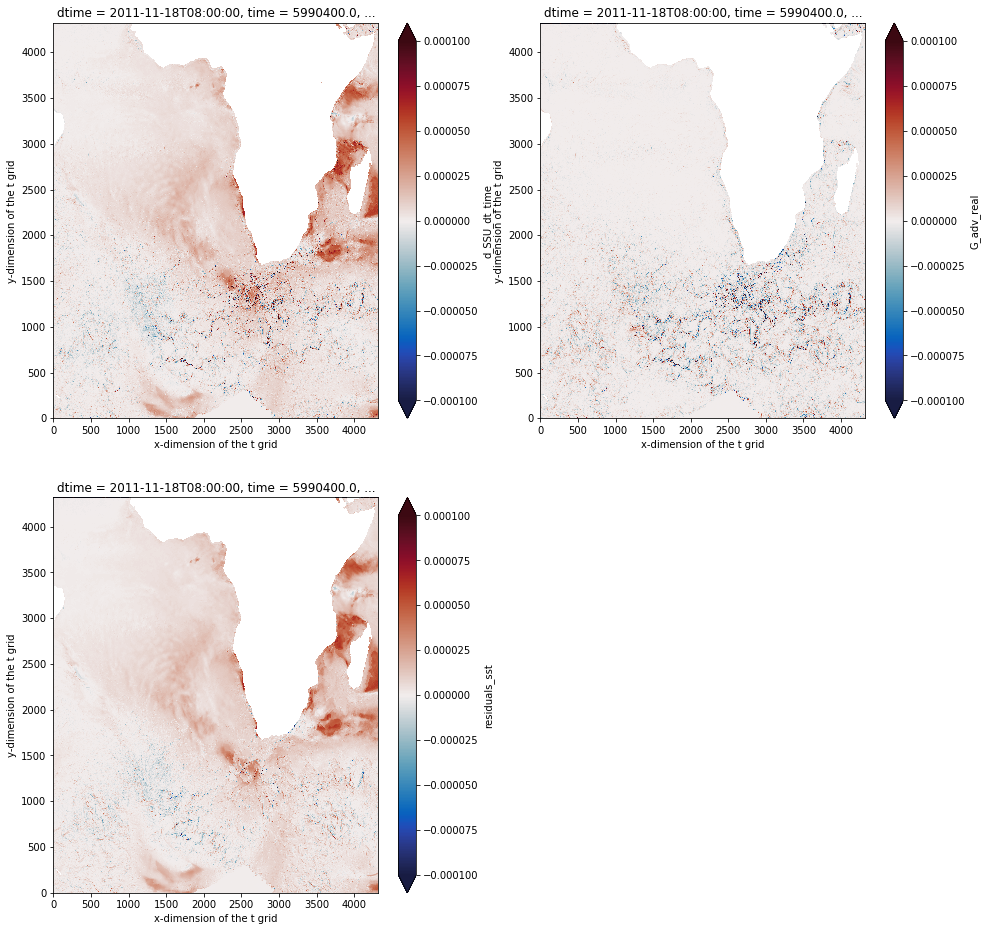

In [29]:
face_plot = 1

fig = plt.figure(figsize = (16,16))

plt.subplot(221)
ds['d_SST_dt_time'].isel(face= face_plot,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['G_adv_real'].isel(face= face_plot,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['residuals_sst'].isel(face= face_plot,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)


### Global maps

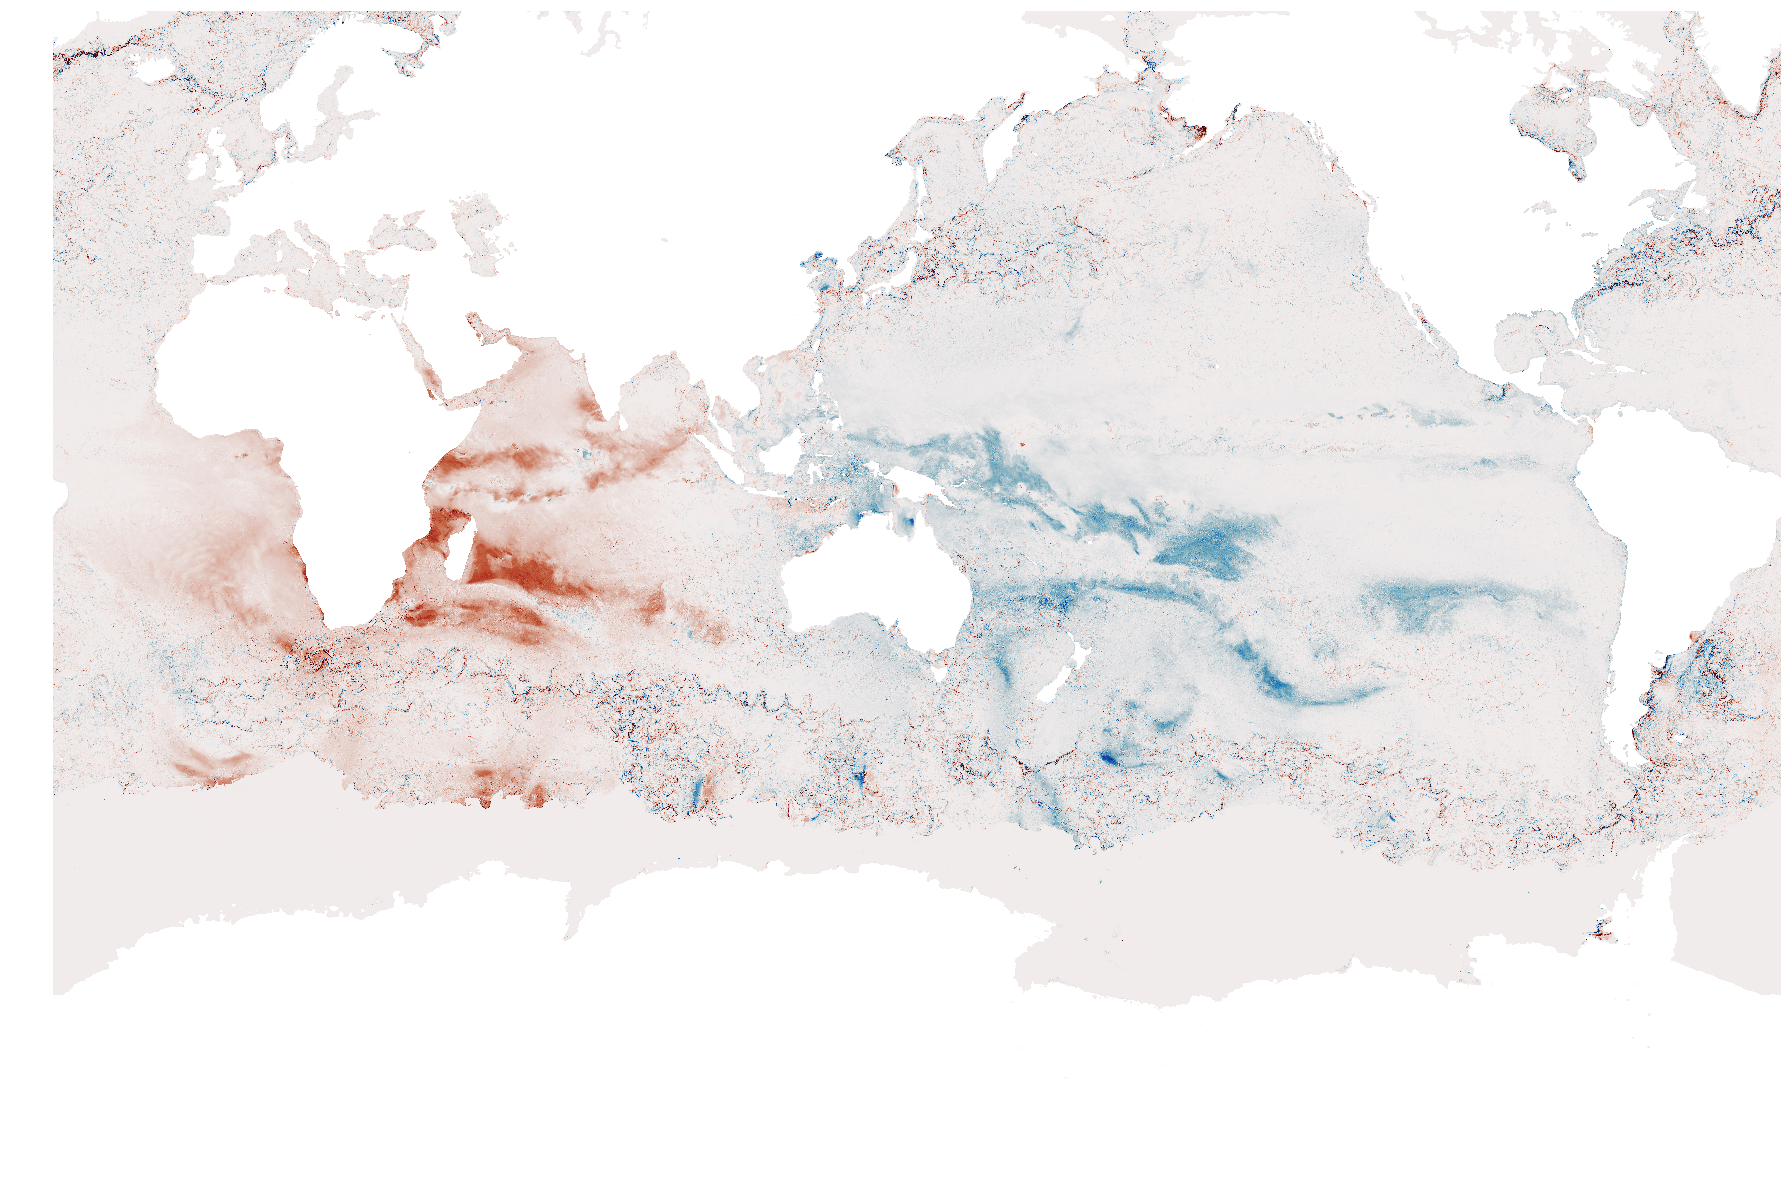

In [39]:
quick_llc_plot(ds['d_SST_dt_time'].isel(time=80), vmin=-0.0001, vmax=0.0001, add_colorbar=False, axis_off=True, cmap = cm.balance)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.0.254:34457 remote=tcp://10.148.0.254:59872>


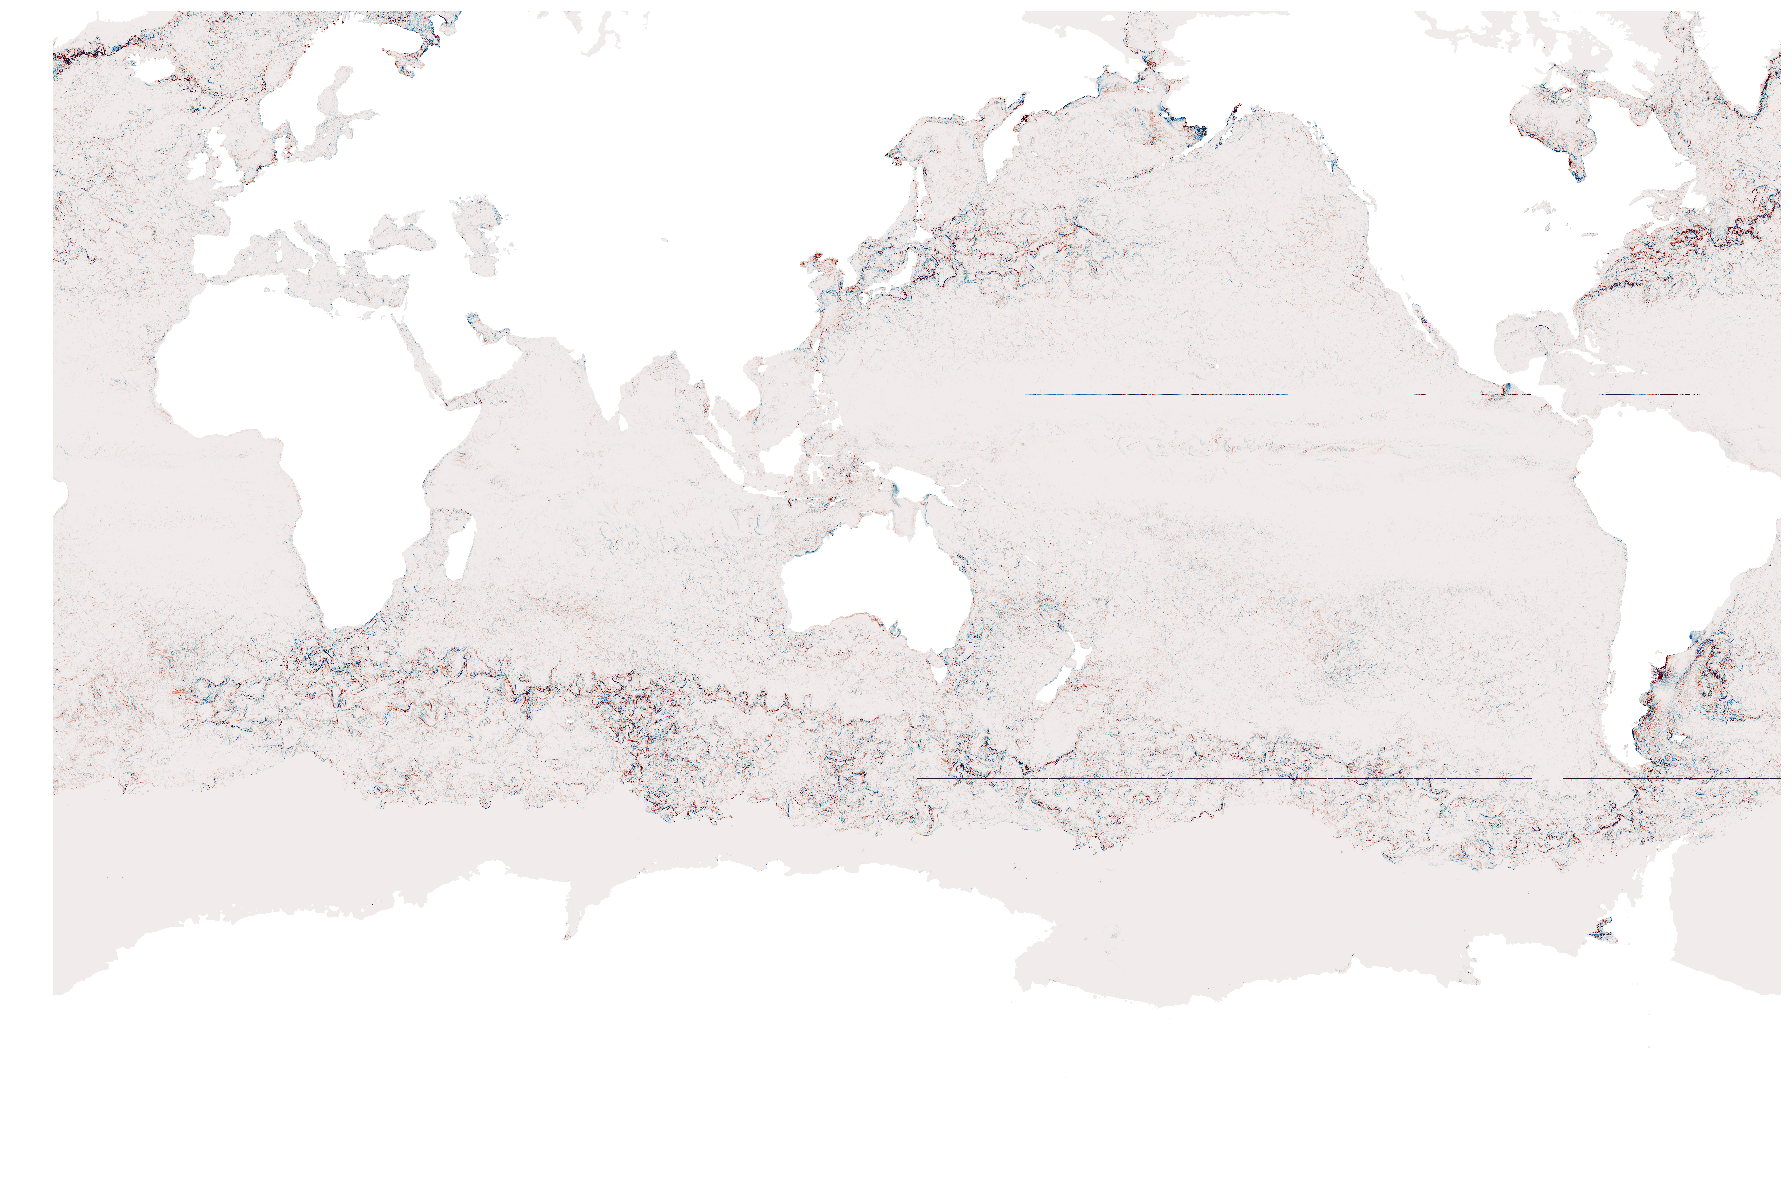

In [40]:
quick_llc_plot(ds['G_adv_real'].isel(time=80), vmin=-0.0001, vmax=0.0001, add_colorbar=False, axis_off=True, cmap = cm.balance)

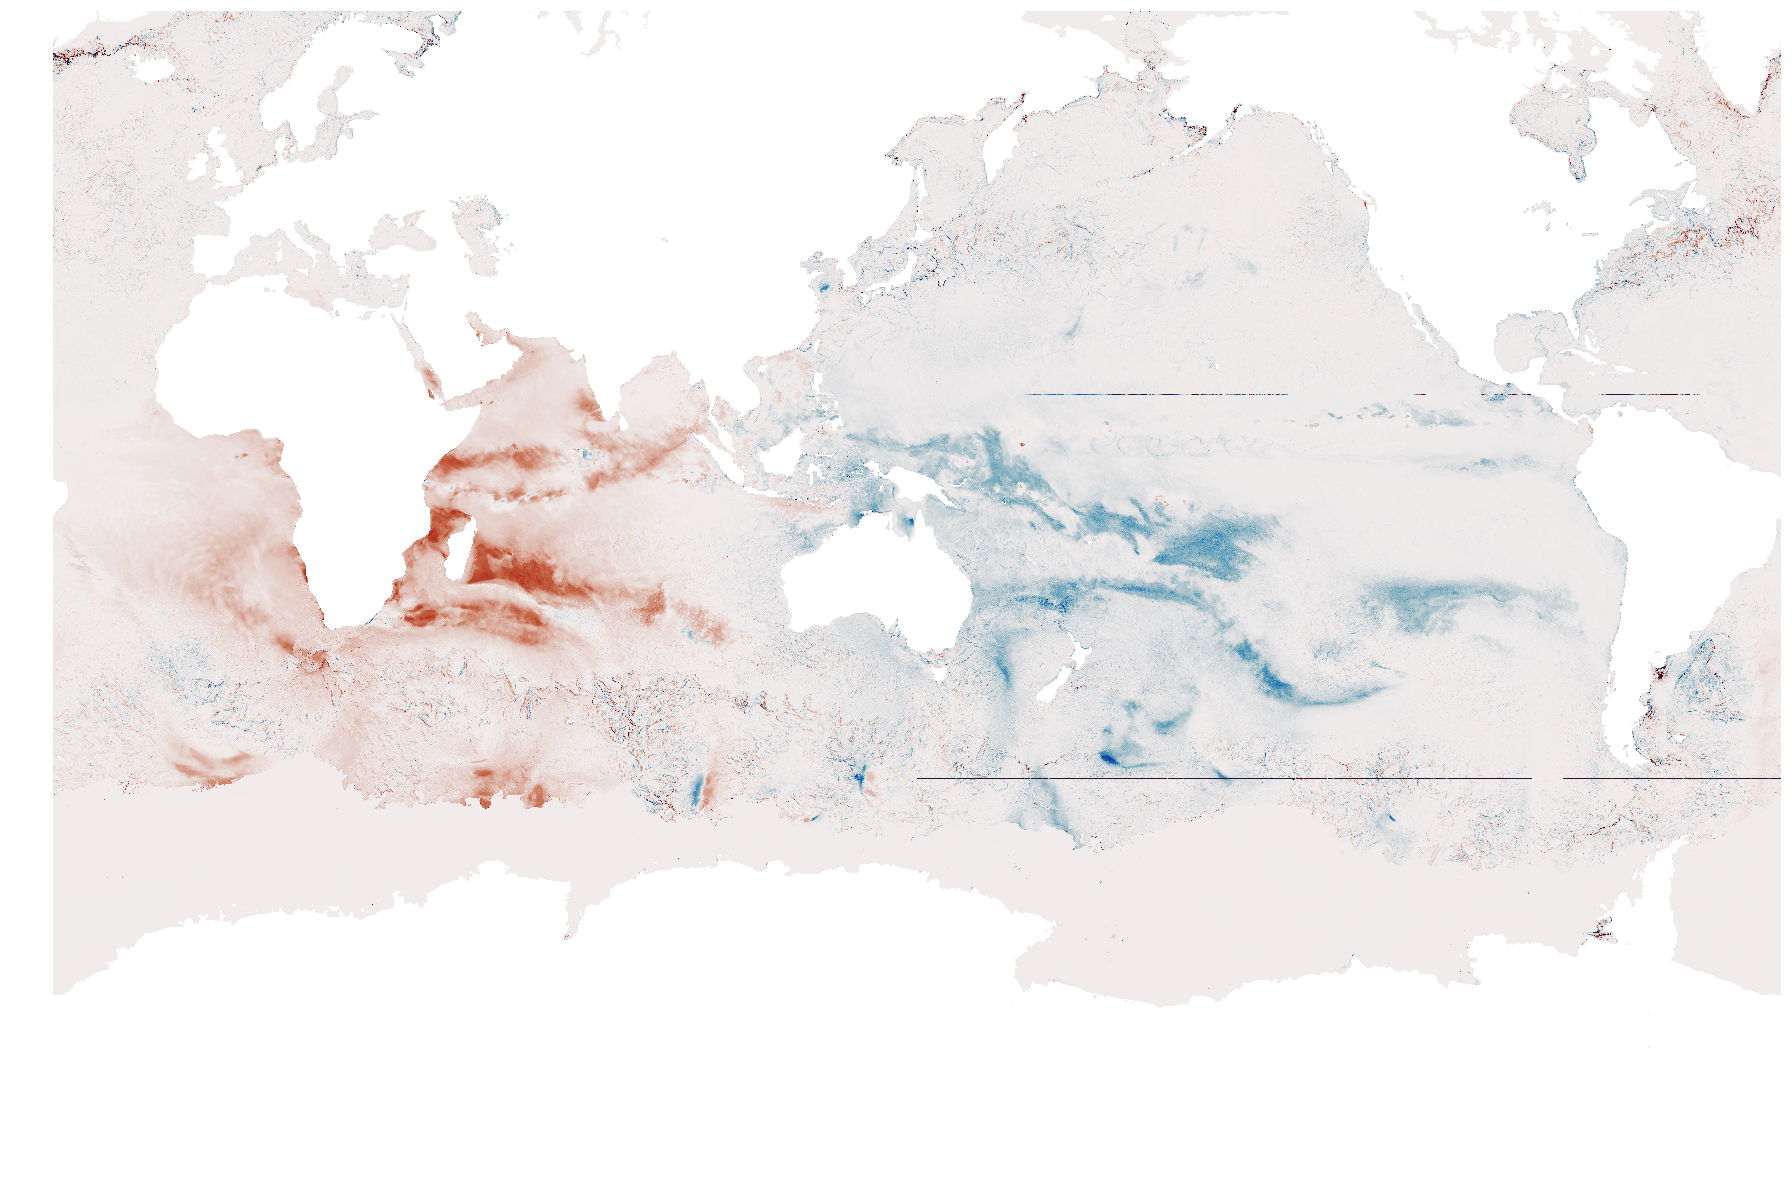

In [41]:
quick_llc_plot(ds['residuals_sst'].isel(time=80), vmin=-0.0001, vmax=0.0001, add_colorbar=False, axis_off=True, cmap = cm.balance)

### movies

In [33]:
def plot_scalar(v1, v2, v3, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(10,10), cmmap='balance'):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        #ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        cmap = getattr(cm, cmmap)
        try:
            
            ## subplot 221
            ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
            im = v1.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            gl.ylabels_right = False
            ax.coastlines(resolution=coast_resolution, color='k')
            ax.set_title(title[0])
            
            
            ## subplot 222
            ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
            im = v2.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            gl.ylabels_right = False
            ax.coastlines(resolution=coast_resolution, color='k')            
            ax.set_title(title[1])            

            
            ## subplot 223
            ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
            im = v3.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            gl.ylabels_right = False
            ax.coastlines(resolution=coast_resolution, color='k')                    
            ax.set_title(title[2])         
                        
        except:
            pass
        #
        #if title is not None:
         #   ax.set_title(title)
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [42]:
from dask import compute, delayed
face = 1
vmin, vmax = -0.0001, 0.0001

figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    d_SST_dt_time = ds['d_SSU_dt_time']
    G_adv_real = ds['G_adv_real']
    residuals_sst = ds['residuals_sst']
    
        
    time = residuals_sst['time'].values/86400.
    figname = figdir+'together_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = ['d_SST_dt_time %.2f' %time, 'G_adv_real %.2f' %time, 'residuals_sst %.2f' %time]
        plot_scalar(d_SST_dt_time, G_adv_real, residuals_sst, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(residuals_sst.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
#I = range(10)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu//mit/figs/
range(0, 720)


In [43]:
%time results = compute(*values, get=client.get)

distributed.client - WARNING - Couldn't gather 7 keys, rescheduling {'process-f16d0af7-aa16-405c-a217-d192044fc62d': (), 'process-fa3d12a5-f1d3-482f-a210-1c5ddee05183': (), 'process-21dd5d13-57ed-44ad-9d44-4bc92f40df97': (), 'process-ba7393f1-af5b-42f4-b68e-4c79e5b1a162': (), 'process-5d2721f6-02ff-402c-8edd-ba9213371efc': (), 'process-9e5c06fa-f49d-429d-b328-9624c93b4f81': (), 'process-d11463bb-161a-4491-9abc-f91e6660b844': ()}


CPU times: user 1min 40s, sys: 7.91 s, total: 1min 48s
Wall time: 11min 26s


In [7]:
cluster.scheduler.close()

<Future finished result=None>

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 842, in _reconnect
    yield self._ensure_connected()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 873, in _ensure_connected
    assert len(msg) == 1
AssertionError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.